# Clustering validation of identified reaction sets 

In [1]:
import os
import umap
import gower
import numpy as np
import pandas as pd
import plotly.express as px
import category_encoders as ce
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs

In [2]:
species = 'pseudomonas_putida'
model_path = 'models/iJN1463.mat'
pseudomonas_results_path = '/'.join(['results', species])
relevant_file = 'condition-specific_enrichment_analysis.xlsx'

### Generate the raw dataframe 

In [3]:
df_list = []
for subdir, dirs, files in os.walk(pseudomonas_results_path):
    for file in files:
        path = os.path.join(subdir, file)
        if relevant_file in path:
            study = path.split('/')[2]
            dfs = pd.read_excel(os.path.join(subdir, file), sheet_name=None)
            for condition in dfs:
                target_df = dfs[condition]
                target_df.pop('Unnamed: 0')
                target_df.pop('target_lenght')
                target_df['Condition'] = [condition.replace('_Presence','')]*len(target_df)
                target_df['Reaction_Set'] = [file.split('_')[0]]*len(target_df)
                target_df['Study'] = [study]*len(target_df)
                df_list.append(target_df)
                
merged_df = pd.concat(df_list)
display(merged_df)

,Subsystem,p-Value,recall,Condition,Reaction_Set,Study
0,S_Transport__ABC_system,3.740472e-43,0.503185,m9-EX_cit_e7.44,NBR,Carbon_Study
1,S_Transport__Inner_Membrane,1.097421e-37,0.519380,m9-EX_cit_e7.44,NBR,Carbon_Study
2,S_Alternate_Carbon_and_Nitrogen_source__Amines...,9.090321e-27,0.714286,m9-EX_cit_e7.44,NBR,Carbon_Study
3,Unassigned,2.162676e-17,0.560000,m9-EX_cit_e7.44,NBR,Carbon_Study
4,S_Transport__Outer_Membrane,5.021249e-15,0.611111,m9-EX_cit_e7.44,NBR,Carbon_Study
...,...,...,...,...,...,...
83,S_Alternate_Carbon__Ascorbate_and_Aldarate_Met...,1.000000e+00,0.000000,m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44,BAR,Muconate_Study
84,S_Alginate_biosynthesis,1.000000e+00,0.000000,m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44,BAR,Muconate_Study
85,S_Alternate_Carbon_and_Nitrogen_source__Hydrox...,1.000000e+00,0.000000,m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44,BAR,Muconate_Study
86,S_Aromatic_Compounds_Degradation__Nicotinic_ac...,1.000000e+00,0.000000,m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44,BAR,Muconate_Study


In [4]:
condition_column = merged_df.Condition.tolist()

In [5]:
#Process Condition column to numerical features
unique_exchanges = set([e.split('_e')[0]+'_e'
                        for c in merged_df.Condition.unique()
                        for e in c.split('-')[1:]])

for exchange in unique_exchanges:    
    merged_df[exchange] = [float(c.split(exchange)[1].split('-')[0])
                           if exchange in c
                           else 0.0
                           for c in merged_df.Condition.tolist()]
    
merged_df.pop('Condition')
display(merged_df)

,Subsystem,p-Value,recall,Reaction_Set,Study,EX_glc_e,EX_fer_e,EX_glcn_e,EX_T4hcinnm_e,EX_fru_e,EX_ser__L_e,EX_cit_e
0,S_Transport__ABC_system,3.740472e-43,0.503185,NBR,Carbon_Study,0.00,0.0,0.00,0.0,0.00,0.0,7.44
1,S_Transport__Inner_Membrane,1.097421e-37,0.519380,NBR,Carbon_Study,0.00,0.0,0.00,0.0,0.00,0.0,7.44
2,S_Alternate_Carbon_and_Nitrogen_source__Amines...,9.090321e-27,0.714286,NBR,Carbon_Study,0.00,0.0,0.00,0.0,0.00,0.0,7.44
3,Unassigned,2.162676e-17,0.560000,NBR,Carbon_Study,0.00,0.0,0.00,0.0,0.00,0.0,7.44
4,S_Transport__Outer_Membrane,5.021249e-15,0.611111,NBR,Carbon_Study,0.00,0.0,0.00,0.0,0.00,0.0,7.44
...,...,...,...,...,...,...,...,...,...,...,...,...
83,S_Alternate_Carbon__Ascorbate_and_Aldarate_Met...,1.000000e+00,0.000000,BAR,Muconate_Study,2.48,0.0,2.48,0.0,0.44,0.0,0.00
84,S_Alginate_biosynthesis,1.000000e+00,0.000000,BAR,Muconate_Study,2.48,0.0,2.48,0.0,0.44,0.0,0.00
85,S_Alternate_Carbon_and_Nitrogen_source__Hydrox...,1.000000e+00,0.000000,BAR,Muconate_Study,2.48,0.0,2.48,0.0,0.44,0.0,0.00
86,S_Aromatic_Compounds_Degradation__Nicotinic_ac...,1.000000e+00,0.000000,BAR,Muconate_Study,2.48,0.0,2.48,0.0,0.44,0.0,0.00


In [6]:
merged_df['EX_ser__L_e'].max()

14.88

In [7]:
categorical_features = ['Subsystem', 'Reaction_Set', 'Study']
numerical_features = ['p-Value', 'recall', 'EX_fru_e', 'EX_glcn_e', 'EX_glc_e', 'EX_T4hcinnm_e', 'EX_fer_e', 'EX_ser__L_e', 'EX_cit_e' ]

### Scale numerical features 

In [8]:
# MinMax scaled
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(merged_df[numerical_features])
numerical_data = scaler.transform(merged_df[numerical_features])
numerical_data = pd.DataFrame(numerical_data,index=merged_df.index,columns=numerical_features)
display(numerical_data.head())

,p-Value,recall,EX_fru_e,EX_glcn_e,EX_glc_e,EX_T4hcinnm_e,EX_fer_e,EX_ser__L_e,EX_cit_e
0,3.740472e-43,0.503185,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.097421e-37,0.519380,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,9.090321e-27,0.714286,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2.162676e-17,0.560000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5.021249e-15,0.611111,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Encode categorical features

In [9]:
#Create object for hash encoder for 'Subsystem' feature
encoder=ce.HashingEncoder(cols='Subsystem', n_components=7)
#Fit and Transform Data
categorical_data = encoder.fit_transform(merged_df)
#Create object for one-hot encoding for 'Reaction_Set' feature
encoder=ce.OneHotEncoder(cols='Reaction_Set',handle_unknown='return_nan',return_df=True,use_cat_names=True)
categorical_data = encoder.fit_transform(categorical_data)
#Create object for one-hot encoding for 'Study' feature
encoder=ce.OneHotEncoder(cols='Study',handle_unknown='return_nan',return_df=True,use_cat_names=True)
categorical_data = encoder.fit_transform(categorical_data).drop(numerical_features, axis=1)
display(categorical_data)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,Reaction_Set_NBR,Reaction_Set_ATP,Reaction_Set_BAR,Study_Carbon_Study,Study_Carbon2_Study,Study_Aromatics_Study,Study_Muconate_Study
0,0,0,0,0,1,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,0,0,0,1,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,0,0,0,0,0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0,0,0,0,0,1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,0,0,0,0,1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,1,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
84,0,0,1,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
85,0,0,1,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
86,0,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [10]:
# transformed and scaled dataset
final_df = pd.concat([numerical_data, categorical_data],axis=1)
print(f'Data min:max {final_df.min().min(),final_df.max().max()}')

Data min:max (0.0, 1.0)


### Perform clustering

In [11]:
display(merged_df)

,Subsystem,p-Value,recall,Reaction_Set,Study,EX_glc_e,EX_fer_e,EX_glcn_e,EX_T4hcinnm_e,EX_fru_e,EX_ser__L_e,EX_cit_e
0,S_Transport__ABC_system,3.740472e-43,0.503185,NBR,Carbon_Study,0.00,0.0,0.00,0.0,0.00,0.0,7.44
1,S_Transport__Inner_Membrane,1.097421e-37,0.519380,NBR,Carbon_Study,0.00,0.0,0.00,0.0,0.00,0.0,7.44
2,S_Alternate_Carbon_and_Nitrogen_source__Amines...,9.090321e-27,0.714286,NBR,Carbon_Study,0.00,0.0,0.00,0.0,0.00,0.0,7.44
3,Unassigned,2.162676e-17,0.560000,NBR,Carbon_Study,0.00,0.0,0.00,0.0,0.00,0.0,7.44
4,S_Transport__Outer_Membrane,5.021249e-15,0.611111,NBR,Carbon_Study,0.00,0.0,0.00,0.0,0.00,0.0,7.44
...,...,...,...,...,...,...,...,...,...,...,...,...
83,S_Alternate_Carbon__Ascorbate_and_Aldarate_Met...,1.000000e+00,0.000000,BAR,Muconate_Study,2.48,0.0,2.48,0.0,0.44,0.0,0.00
84,S_Alginate_biosynthesis,1.000000e+00,0.000000,BAR,Muconate_Study,2.48,0.0,2.48,0.0,0.44,0.0,0.00
85,S_Alternate_Carbon_and_Nitrogen_source__Hydrox...,1.000000e+00,0.000000,BAR,Muconate_Study,2.48,0.0,2.48,0.0,0.44,0.0,0.00
86,S_Aromatic_Compounds_Degradation__Nicotinic_ac...,1.000000e+00,0.000000,BAR,Muconate_Study,2.48,0.0,2.48,0.0,0.44,0.0,0.00


In [12]:
display(final_df)

,p-Value,recall,EX_fru_e,EX_glcn_e,EX_glc_e,EX_T4hcinnm_e,EX_fer_e,EX_ser__L_e,EX_cit_e,col_0,...,col_4,col_5,col_6,Reaction_Set_NBR,Reaction_Set_ATP,Reaction_Set_BAR,Study_Carbon_Study,Study_Carbon2_Study,Study_Aromatics_Study,Study_Muconate_Study
0,3.740472e-43,0.503185,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0,...,1,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.097421e-37,0.519380,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0,...,1,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,9.090321e-27,0.714286,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0,...,0,0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2.162676e-17,0.560000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0,...,0,1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,5.021249e-15,0.611111,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0,...,0,1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,1.000000e+00,0.000000,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,1,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
84,1.000000e+00,0.000000,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
85,1.000000e+00,0.000000,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
86,1.000000e+00,0.000000,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [13]:
cat = [True if x in categorical_features else False for x in merged_df.columns]
gd = gower.gower_matrix(merged_df, cat_features=cat)
gd_df = pd.DataFrame(gd)

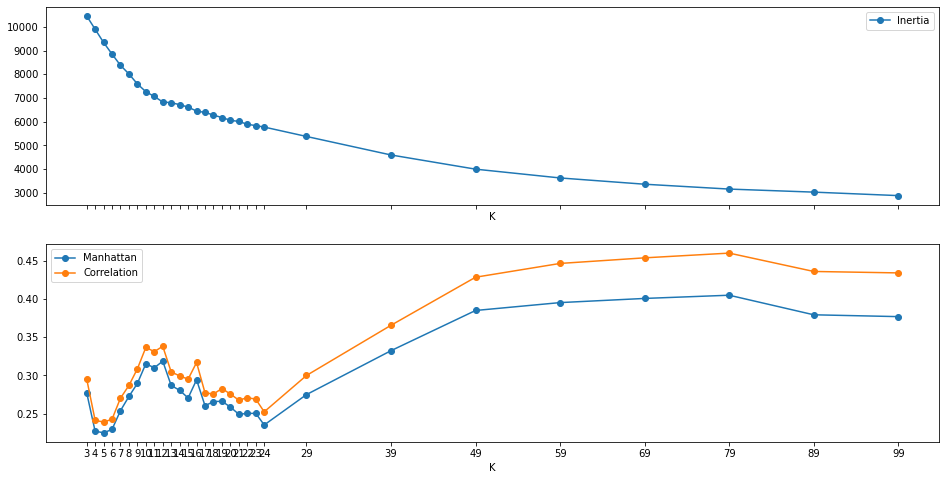

In [32]:
results = dict()
k_cand = list(np.arange(3,25,1))
k_cand.extend(np.arange(29, 100, 10))

for k in k_cand:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(final_df)
    score0 = kmeans.inertia_
    score1 = silhouette_score(final_df,kmeans.labels_,metric='manhattan')
    score2 = silhouette_score(final_df,kmeans.labels_,metric='correlation')
    results[k] = {'k':kmeans,'s0':score0,'s1':score1,'s2':score2}

fig,axs = plt.subplots(2,1,sharex=True,figsize=(16,8))
axs[0].plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Inertia')
axs[1].plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Manhattan')
axs[1].plot([i for i in results.keys()],[i['s2'] for i in results.values()],'o-',label='Correlation')
for ax in axs:
    ax.set_xticks(k_cand)
    ax.set_xlabel('K')
    ax.legend()


In [34]:
tsne_model = TSNE(n_components=2, perplexity=2000, verbose=1, random_state=2, n_iter=500)
tsne = tsne_model.fit_transform(final_df)
tsne = pd.DataFrame(tsne)
tsne['k'] = results[10]['k'].labels_
tsne.rename(columns={0: "t-SNE 1", 1: "t-SNE 2"}, inplace=True)
#pass to plotly plot to map categorical varibles
tsne['k'] = tsne['k'].astype(str)
tsne['Reaction_Set'] = merged_df['Reaction_Set'].tolist()
tsne['Subsystem'] = merged_df['Subsystem'].tolist()
tsne['Condition'] = condition_column
tsne['Study'] = merged_df['Study'].tolist()

fig = px.scatter(tsne,
                 x="t-SNE 1", y="t-SNE 2",
                 color='k',
                 symbol='Reaction_Set',
                 hover_data=['Subsystem', 'Condition', 'Study'],
                 color_discrete_sequence=px.colors.qualitative.Plotly)

fig.update_layout(plot_bgcolor= 'white',
                  width = 1000,
                  height = 800)

fig.update_traces(marker_size=6)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

fig.show()

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 4223 nearest neighbors...
[t-SNE] Indexed 4224 samples in 0.000s...
[t-SNE] Computed neighbors for 4224 samples in 0.909s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4224
[t-SNE] Computed conditional probabilities for sample 2000 / 4224
[t-SNE] Computed conditional probabilities for sample 3000 / 4224
[t-SNE] Computed conditional probabilities for sample 4000 / 4224
[t-SNE] Computed conditional probabilities for sample 4224 / 4224
[t-SNE] Mean sigma: 1.300283
[t-SNE] KL divergence after 50 iterations with early exaggeration: 38.611492
[t-SNE] KL divergence after 500 iterations: 0.332971


In [36]:
cluster_rxn_study_dict = {}

for cluster in tsne.k.unique().tolist():
    studies = tsne.loc[tsne['k']==cluster, 'Study'].unique().tolist()
    rxns = tsne.loc[tsne['k']==cluster, 'Reaction_Set'].unique().tolist()
    cluster_rxn_study_dict['_'.join(['cluster', cluster])] = { 'Study' : studies, 'Reaction_Set' : rxns }

cluster_rxn_study_dict

{'cluster_2': {'Study': ['Carbon_Study'], 'Reaction_Set': ['NBR']},
 'cluster_8': {'Study': ['Carbon_Study'], 'Reaction_Set': ['ATP']},
 'cluster_4': {'Study': ['Carbon_Study'], 'Reaction_Set': ['BAR']},
 'cluster_9': {'Study': ['Carbon2_Study'],
  'Reaction_Set': ['NBR', 'ATP', 'BAR']},
 'cluster_1': {'Study': ['Carbon2_Study', 'Muconate_Study'],
  'Reaction_Set': ['ATP']},
 'cluster_3': {'Study': ['Aromatics_Study'], 'Reaction_Set': ['NBR']},
 'cluster_7': {'Study': ['Aromatics_Study'], 'Reaction_Set': ['ATP']},
 'cluster_6': {'Study': ['Aromatics_Study'], 'Reaction_Set': ['BAR']},
 'cluster_0': {'Study': ['Muconate_Study'], 'Reaction_Set': ['NBR']},
 'cluster_5': {'Study': ['Muconate_Study'], 'Reaction_Set': ['BAR']}}

In [40]:
num_clusters = 10
neighbors = 200
distance = 0.99
random_state = 2

umap_embedding = (umap
                  .UMAP(metric='dice', n_neighbors=neighbors, min_dist=distance, n_components=2)
                  .fit_transform(final_df))
                  
                  
clusters = (KMeans(n_clusters=num_clusters, init='k-means++',
                  verbose=0, random_state=random_state,
                  algorithm='lloyd')
            .fit(umap_embedding)
            .labels_)


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning:

gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable



In [41]:
plot_data = {'UMAP_1' : umap_embedding[:, 0],
             'UMAP_2' : umap_embedding[:, 1],
             'Cluster' : clusters,
             'Reaction_Set' : merged_df['Reaction_Set'].tolist(),
             'Subsystem' : merged_df['Subsystem'].tolist(),
             'Condition' : condition_column,
             'Study' : merged_df['Study'].tolist()}

umap_df = pd.DataFrame.from_dict(plot_data)
display(umap_df)

,UMAP_1,UMAP_2,Cluster,Reaction_Set,Subsystem,Condition,Study
0,29.454815,18.328138,9,NBR,S_Transport__ABC_system,m9-EX_cit_e7.44,Carbon_Study
1,29.410131,18.556507,9,NBR,S_Transport__Inner_Membrane,m9-EX_cit_e7.44,Carbon_Study
2,-6.041417,18.173059,3,NBR,S_Alternate_Carbon_and_Nitrogen_source__Amines...,m9-EX_cit_e7.44,Carbon_Study
3,-10.427271,6.675970,1,NBR,Unassigned,m9-EX_cit_e7.44,Carbon_Study
4,-10.616695,6.751623,1,NBR,S_Transport__Outer_Membrane,m9-EX_cit_e7.44,Carbon_Study
...,...,...,...,...,...,...,...
4219,-7.387034,13.112072,3,BAR,S_Alternate_Carbon__Ascorbate_and_Aldarate_Met...,m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44,Muconate_Study
4220,31.172197,-6.401341,4,BAR,S_Alginate_biosynthesis,m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44,Muconate_Study
4221,31.227114,-6.263746,4,BAR,S_Alternate_Carbon_and_Nitrogen_source__Hydrox...,m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44,Muconate_Study
4222,16.102173,-20.934849,8,BAR,S_Aromatic_Compounds_Degradation__Nicotinic_ac...,m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44,Muconate_Study


In [42]:
umap_df["Cluster"] = umap_df["Cluster"].astype(str)

fig = px.scatter(umap_df,
                 x="UMAP_1", y="UMAP_2",
                 color='Cluster',
                 symbol='Reaction_Set',
                 hover_data=['Subsystem', 'Condition'],
                 color_discrete_sequence=px.colors.qualitative.Dark24)

fig.update_layout(plot_bgcolor= 'white',
                  width = 1000,
                  height = 800)

fig.update_traces(marker_size=6)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

fig.show()